# Evaluation

This notebook runs ASR on the models.

In [1]:
# Import packages
import pandas as pd
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import librosa
import editdistance
from g2p_en import G2p
g2p = G2p()
import nltk
#import os

/opt/anaconda3/envs/lora_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: Failed to import transformers.models.wav2vec2.modeling_wav2vec2 because of the following error (look up to see its traceback):
Failed to import transformers.generation.utils because of the following error (look up to see its traceback):
All ufuncs must have type `numpy.ufunc`. Received (<ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>)

In [11]:
# nltk.download('averaged_perceptron_tagger_en')
# nltk.download('punkt')
g2p = G2p()

In [2]:
def load_audio(file_path):
    '''
    Load audio file from filepath.
    '''
    audio, _ = librosa.load(file_path, sr=16000)
    return audio


def transcribe_audio(model, proc, file_name):
    '''
    Transcribes audio using defined model.
    '''
    audio = load_audio(file_name)
    
    input_vals = proc(
        audio, 
        return_tensors = 'pt',
        sampling_rate = 16000
    ).input_values 

    with torch.no_grad():
        logits = model(input_vals).logits 
        
    predicted_ids = torch.argmax(logits, dim = -1)
    predicted_word = proc.decode(predicted_ids[0])
    
    return predicted_word.lower()


def get_phones(text):
    '''
    Get phones from G2p mapping.
    '''
    phones = g2p(text)
    if " " in phones:
        phones.remove(" ")
    return phones


def compute_phone_edit_distance(predicted, reference):
    '''
    Computes normalized edit distance between predicted phones and true (canonical) phones.
    '''
    return editdistance.eval(predicted, reference) / max(len(reference), 1)


def load_model(model_path):
    '''
    Loads model from local model filepath.
    '''
    model = Wav2Vec2ForCTC.from_pretrained(model_path)
    proc = Wav2Vec2Processor.from_pretrained(model_path)

    return model, proc


def transcribe_dataset(df, models):
    '''
    Makes ASR predictions of audio files for each model. 
    Gets phone mappings of transcription and predictions. 
    Calculates edit distance between prediction phones and true (canonical) phones.

    Parameters: 
    -----------
    df : pandas DataFrame
    models : dictionary of models

    Returns:
    --------
    df : updated DataFrame with predictions, phones, and edit distance for each model.
    '''
    
    # get phones of transcription
    df['transcription_phones'] = df["transcription"].apply(lambda x: get_phones(x))
    
    # get predictions, phones, and edit distance from models
    for i in models.keys():
        model_name = i
        model_path = models[i]

        model, proc = load_model(model_path)

        # get predictions
        pred_col = model_name + '_pred'
        df[pred_col] = df["file_name"].apply(lambda x: transcribe_audio(model, proc, x))
        
        # get phones
        phones_col = model_name + '_phones'
        df[phones_col] = df[pred_col].apply(lambda x: get_phones(x))

        # compute edit distance
        distance_col = model_name + '_edit_distance'
        df[distance_col] = df.apply(
            lambda row: compute_phone_edit_distance(row[phones_col], row['transcription_phones']),
            axis=1
        )

def calculate_accuracy(column, df):
    '''
    Calculate grapheme-based accuracy, proportion of correct predictions over all predictions.
    '''
    num_correct = (df['transcription'] == df[column]).sum()
    num_total = len(df)
    proportion = num_correct/num_total
    return round(proportion, 4)
            


def make_accuracy_df(kids_df, adults_df, model_columns, learning_rates):
    """
    Calculates accuracy, edit distance, standard errors, and proportion of null predictions
    for kids and adults across different ASR models.

    Parameters:
    -----------
    kids_df : DataFrame containing kids' ASR predictions.
    adults_df : DataFrame containing adults' ASR predictions.
    model_columns : list of prediction column names (e.g., '1e4_pred').
    learning_rates : list of learning rates corresponding to model_columns (same order).

    Returns:
    --------
    accuracy_df : DataFrame with accuracy, mean edit distance, standard errors,
                  and proportion of null predictions for each learning rate and age group.
    """

    metrics = []

    for col, rate in zip(model_columns, learning_rates):
        for group_name, df in zip(["kid_accuracy", "adult_accuracy"], [kids_df, adults_df]):
            
            # Sample size
            n = len(df)

            # Calculate accuracy
            accuracy = calculate_accuracy(col, df)
            se_accuracy = np.sqrt(accuracy * (1 - accuracy) / n)

            # Calculate mean edit distance and standard error
            distance_col = col.replace("_pred", "_edit_distance")
            mean_edit_distance = df[distance_col].mean()
            se_edit_distance = df[distance_col].std(ddof=1) / np.sqrt(n)

            # Calculate proportion of null predictions
            null_proportion = df[col].isna().sum() / n

            # Add metrics to list
            metrics.append({
                "learning_rate": rate,
                "group": group_name,
                "accuracy": accuracy,
                "se_accuracy": se_accuracy,
                "mean_edit_distance": mean_edit_distance,
                "se_edit_distance": se_edit_distance,
                "null_proportion": null_proportion
            })

    return pd.DataFrame(metrics)



In [3]:
kids_df = pd.read_csv("./kids_eval.csv")
adults_df = pd.read_csv("./adults_eval.csv")
models = {
    "0" : "facebook/wav2vec2-base-960h",
    "1e10" : "./w2v2960h_lr1e10",
    "1e9" : "./w2v2960h_lr1e9",
    "1e8" : "./w2v2960h_lr1e8",
    "1e7" : './w2v2960h_lr1e7',
    "1e6" : './w2v2960h_lr1e6',
    "1e5" : './w2v2960h_lr1e5',
    "1e4" : './w2v2960h_lr1e4',
    "1e3" : "./w2v2960h_lr1e3",
    "1e2" : "./w2v2960h_lr1e2"
}

In [14]:
# Run ASR
transcribe_dataset(kids_df, models)
kids_df.to_csv("kids_eval.csv", index=False)

transcribe_dataset(adults_df, models)
adults_df.to_csv("adults_eval.csv", index=False)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
columns = ['0_pred', '1e10_pred','1e9_pred', '1e8_pred', '1e7_pred', '1e6_pred', '1e5_pred', '1e4_pred','1e3_pred','1e2_pred']
rates = [0, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]  # match order

accuracy_df = make_accuracy_df(kids_df, adults_df, columns, rates)
accuracy_df.to_csv("eval_metrics.csv", index=False)
accuracy_df

,learning_rate,group,accuracy,se_accuracy,mean_edit_distance,se_edit_distance,null_proportion
0,0.000000e+00,kid_accuracy,0.1128,0.015837,0.705054,0.022365,0.047619
1,0.000000e+00,adult_accuracy,0.5875,0.024614,0.223708,0.017229,0.007500
2,1.000000e-10,kid_accuracy,0.1128,0.015837,0.705054,0.022365,0.047619
3,1.000000e-10,adult_accuracy,0.5875,0.024614,0.223708,0.017229,0.007500
4,1.000000e-09,kid_accuracy,0.1128,0.015837,0.705054,0.022365,0.047619
5,1.000000e-09,adult_accuracy,0.5875,0.024614,0.223708,0.017229,0.007500
6,1.000000e-08,kid_accuracy,0.1128,0.015837,0.705890,0.022377,0.047619
7,1.000000e-08,adult_accuracy,0.5875,0.024614,0.223708,0.017229,0.007500
8,1.000000e-07,kid_accuracy,0.1153,0.015989,0.699039,0.023030,0.052632
9,1.000000e-07,adult_accuracy,0.5900,0.024592,0.221417,0.017102,0.010000


In [7]:
# dir = "/home/cogsci-lasrlab/Documents/CSS_Capstone/researcher"

# files = []
# words = []

# for file in os.listdir(dir):
#     path = dir+"/"+file
#     files.append(path)

#     if file.endswith('.wav') and "researcher_" in file:
#         base = file[:-4]  # remove '.wav'
#         before, text = base.split("researcher_")

#         words.append(text)

# adults_df = pd.DataFrame({
#     "file_name":files,
#     "transcription":words
# })

# sample_adults_df = adults_df.sample(n=400, random_state=123)
# sample_adults_df

# sample_adults_df.to_csv("adults_eval.csv", index=False)

In [22]:
# columns = ['lr1e4_pred', 'lr1e5_pred', 'lr1e6_pred', 'lr1e7_pred', 'lr1e8_pred', 'lr0_pred']
# columns = columns[::-1]
# rates = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

# kid_accuracy = []
# adult_accuracy = []

# for col in columns:
#     kid_accuracy.append(calculate_accuracy(col, kids_df))
#     adult_accuracy.append(calculate_accuracy(col, adults_df))
    
# accuracy_df = pd.DataFrame({
#     "learning_rate" : rates,
#     "kid_accuracy" : kid_accuracy,
#     "adult_accuracy" : adult_accuracy
# })

# accuracy_df = accuracy_df.melt(
#     id_vars="learning_rate",
#     value_vars=["kid_accuracy", "adult_accuracy"],
#     var_name="group",
#     value_name="accuracy"
# )

# accuracy_df

# Plots

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [15]:
accuracy_df = pd.read_csv('eval_metrics.csv')
kids_df = pd.read_csv('kids_eval.csv')
adults_df = pd.read_csv('adults_eval.csv')

In [16]:
accuracy_df

,learning_rate,group,accuracy,se_accuracy,mean_edit_distance,se_edit_distance,null_proportion
0,0.000000e+00,kid_accuracy,0.1128,0.015837,0.705054,0.022365,0.047619
1,0.000000e+00,adult_accuracy,0.5875,0.024614,0.223708,0.017229,0.007500
2,1.000000e-10,kid_accuracy,0.1128,0.015837,0.705054,0.022365,0.047619
3,1.000000e-10,adult_accuracy,0.5875,0.024614,0.223708,0.017229,0.007500
4,1.000000e-09,kid_accuracy,0.1128,0.015837,0.705054,0.022365,0.047619
5,1.000000e-09,adult_accuracy,0.5875,0.024614,0.223708,0.017229,0.007500
6,1.000000e-08,kid_accuracy,0.1128,0.015837,0.705890,0.022377,0.047619
7,1.000000e-08,adult_accuracy,0.5875,0.024614,0.223708,0.017229,0.007500
8,1.000000e-07,kid_accuracy,0.1153,0.015989,0.699039,0.023030,0.052632
9,1.000000e-07,adult_accuracy,0.5900,0.024592,0.221417,0.017102,0.010000


In [17]:
sns.set_theme(style="whitegrid", palette="colorblind")

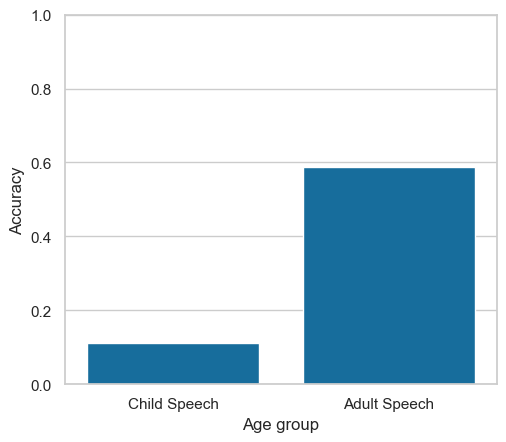

In [18]:
baseline_df = accuracy_df.head(2)

sns.barplot(baseline_df, x = 'group', y= 'accuracy')
#plt.title("Baseline wav2vec2-base-960h Accuracy by Age Group")
plt.xlabel('Age group')
plt.xticks(ticks=baseline_df['group'], labels=['Child Speech', 'Adult Speech'])
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.0)
plt.subplots_adjust(right=0.8)  # shift plot to the left to make space

fig = plt.gcf()

# Save the figure
fig.savefig('accuracy_bar.png', dpi=300)

plt.show()

/var/folders/jb/3gk3p4nn5tlcdvb5zkgy4xh40000gn/T/ipykernel_42413/618621802.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=baseline_df, x='group', y='accuracy', ci=None)


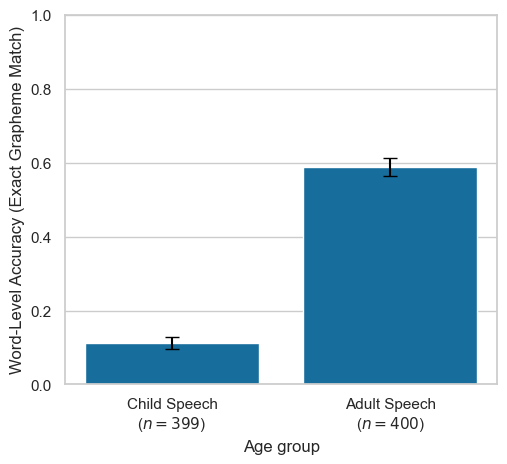

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

baseline_df = accuracy_df.head(2)

# Create the barplot without built-in confidence intervals
sns.barplot(data=baseline_df, x='group', y='accuracy', ci=None)

# Add error bars manually
plt.errorbar(
    x=[0, 1],  # positions for 'Child Speech' and 'Adult Speech'
    y=baseline_df['accuracy'],
    yerr=baseline_df['se_accuracy'],
    fmt='none',  # no marker
    ecolor='black',  # color of error bars
    capsize=5,  # length of the error bar caps
    linewidth=1.5
)

# Customize the plot
plt.xlabel('Age group')
plt.xticks(ticks=[0, 1], labels=['Child Speech\n($n=399$)', 'Adult Speech\n($n=400$)'])
plt.ylabel("Word-Level Accuracy (Exact Grapheme Match)")
plt.ylim(0.0, 1.0)
plt.subplots_adjust(right=0.8)

# Save and show
fig = plt.gcf()
fig.savefig('accuracy_bar.png', dpi=300)
plt.show()


/var/folders/jb/3gk3p4nn5tlcdvb5zkgy4xh40000gn/T/ipykernel_42413/1061882074.py:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 10^-2)


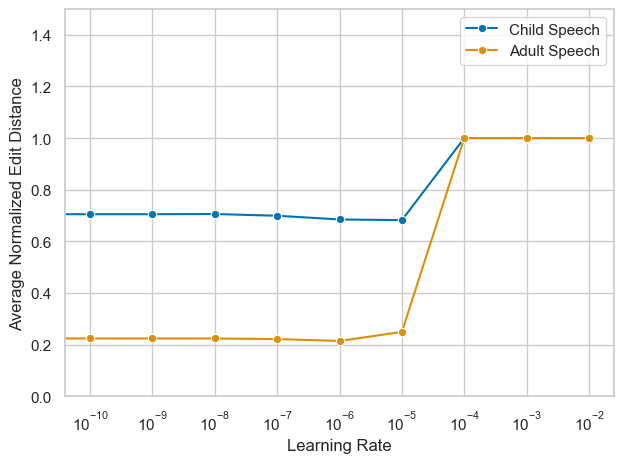

In [19]:
sns.lineplot(data=accuracy_df, x='learning_rate', y='mean_edit_distance', hue='group', marker='o')
#plt.xticks(rotation=45)  # optional: rotate x-axis labels if they overlap
#plt.title("Normalized Edit Distance by Learning Rate and Age Group")

plt.xscale('log')
plt.xlim(0, 10^-2)
plt.xlabel('Learning Rate')
plt.ylabel('Average Normalized Edit Distance')
plt.ylim(0, 1.5)

#plt.axhline(y=1.0, color='r', linestyle='--', label="100% mismatch")

L = plt.legend()
L.get_texts()[0].set_text('Child Speech')
L.get_texts()[1].set_text('Adult Speech')


plt.tight_layout()
fig = plt.gcf()

# Save the figure
fig.savefig('edit_distance_line.png', dpi=300)

plt.show()

/var/folders/jb/3gk3p4nn5tlcdvb5zkgy4xh40000gn/T/ipykernel_42413/1147767340.py:19: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0, 10**-2)


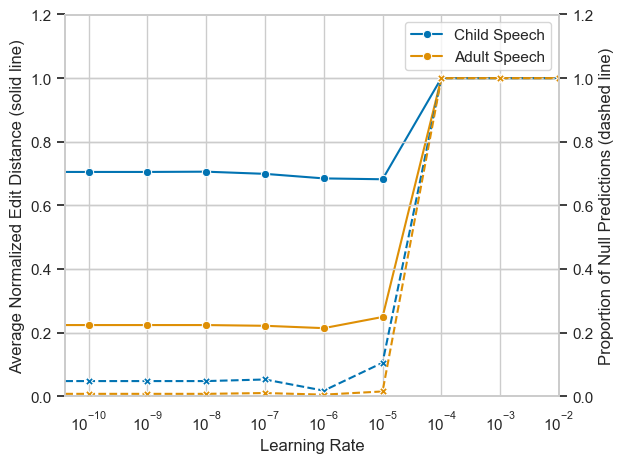

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure and primary axis
fig, ax1 = plt.subplots()

# Plot mean edit distance
sns.lineplot(
    data=accuracy_df,
    x='learning_rate',
    y='mean_edit_distance',
    hue='group',
    marker='o',
    ax=ax1
)

# Customize primary y-axis (mean edit distance)
ax1.set_xscale('log')
ax1.set_xlim(0, 10**-2)
ax1.set_ylim(0, 1.2)
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Average Normalized Edit Distance (solid line)')

# Legend adjustments
L = ax1.legend()
L.get_texts()[0].set_text('Child Speech')
L.get_texts()[1].set_text('Adult Speech')

# Create secondary y-axis
ax2 = ax1.twinx()

# Plot null proportion line (combined across both groups for simplicity; can separate if needed)
sns.lineplot(
    data=accuracy_df,
    x='learning_rate',
    y='null_proportion',
    hue='group',
    marker='X',
    linestyle='--',
    ax=ax2,
    legend=False  # disable second legend
)

# Customize secondary y-axis (null proportion)
ax2.set_ylabel('Proportion of Null Predictions (dashed line)')
ax2.set_ylim(0, 1.2)

# Adjust layout and save
plt.tight_layout()
fig.savefig('edit_distance_with_nulls.png', dpi=300)
plt.show()


In [145]:
optimal_kids_df = kids_df[['file_name', 'ppt_id', 'transcription', 'transcription_phones', 'lr1e5_pred', '1e5_phones', '1e5_edit_distance']]
optimal_kids_df.to_csv('optimal_preds.csv', index=False)

In [315]:
def get_top_predictions(word, df, pred_col='lr1e5_pred', top_n=5):
    preds = df[df['transcription'] == word][pred_col]
    counts = preds.value_counts().head(top_n)
    proportions = (counts / len(preds)).round(3)  # proportion relative to this word only
    return proportions.to_dict()

def generate_error_summary(df, pred_col='lr1e5_pred', dist_col='1e5_edit_distance', top_n=24):
    df_filtered = df[df[pred_col].notna()]
    total_count = len(df_filtered)  # Use actual filtered length

    grouped = (
        df_filtered.groupby('transcription')
        .agg(
            avg_edit_distance=(dist_col, 'mean'),
            most_common_prediction=(pred_col, lambda x: x.value_counts().idxmax())
        )
        .reset_index()
    )
    
    grouped['top_5_predictions'] = grouped['transcription'].apply(
        lambda w: get_top_predictions(w, df_filtered, pred_col, top_n=5)
    )

    return grouped.sort_values(by='avg_edit_distance', ascending=False).head(top_n)


# Example use:
worst_words_df = generate_error_summary(optimal_kids_df, pred_col='lr1e5_pred', dist_col='1e5_edit_distance')
worst_words_df

adult_worst_df = generate_error_summary(adults_df, pred_col='lr1e5_pred', dist_col='1e5_edit_distance')
worst_words_df = pd.merge(worst_words_df, adult_worst_df, on='transcription')

worst_words_df.to_csv('top_predictions.csv', index=False)
worst_words_df.head()


,transcription,avg_edit_distance_x,most_common_prediction_x,top_5_predictions_x,avg_edit_distance_y,most_common_prediction_y,top_5_predictions_y
0,zoo,1.088235,sail,"{'sail': 0.118, 'no': 0.059, 'here': 0.059, 'l...",0.961538,zeal,"{'zeal': 0.385, 'sill': 0.154, 'zl': 0.077, 'z..."
1,shoe,1.029412,sho,"{'sho': 0.176, 'shil': 0.118, 'you': 0.059, 'h...",0.366667,shoe,"{'shoe': 0.533, 'shi': 0.067, 'she': 0.067, 'h..."
2,leg,0.901961,red,"{'red': 0.059, 'rel': 0.059, 'lade': 0.059, 'm...",0.547619,lake,"{'lake': 0.571, 'leg': 0.214, 'lad': 0.071, 'f..."
3,chip,0.833333,chip,"{'chip': 0.2, 'se': 0.1, 'cip': 0.1, 'so': 0.1...",0.277778,chip,"{'chip': 0.611, 'chi': 0.111, 'ch': 0.111, 'ch..."
4,chick,0.833333,o,"{'o': 0.167, 's': 0.167, 'sock': 0.167, 'a cha...",0.355556,check,"{'check': 0.333, 'chick': 0.267, 'kick': 0.133..."


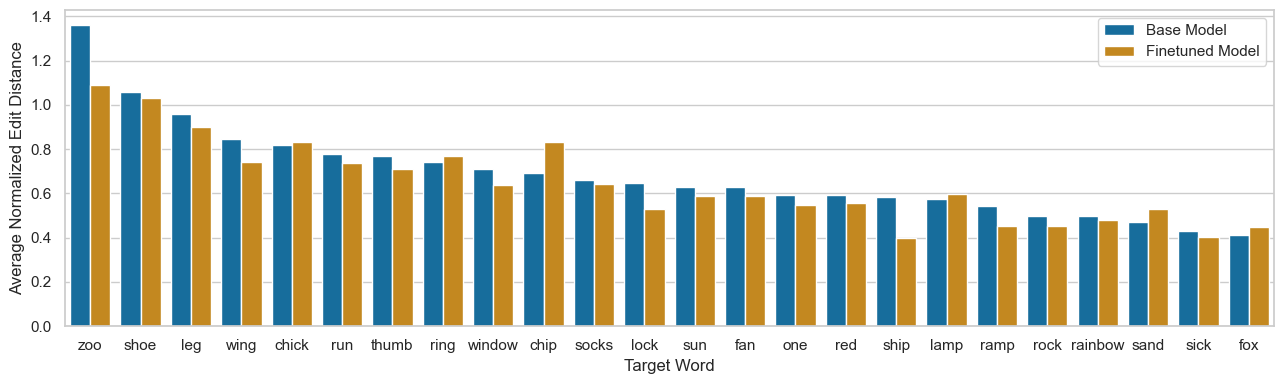

In [336]:
base_df = generate_error_summary(kids_df, pred_col='base_pred', dist_col='0_edit_distance')
finetuned_df = generate_error_summary(kids_df, pred_col='lr1e5_pred', dist_col='1e5_edit_distance')
models_df = pd.merge(base_df, finetuned_df, on='transcription')

melted_models_df = models_df.melt(
    id_vars='transcription',
    value_vars=['avg_edit_distance_x', 'avg_edit_distance_y'],
    var_name='Model',
    value_name='Avg Edit Distance'
)

fig, ax = plt.subplots(figsize=(13, 4))
sns.barplot(data=melted_models_df, x='transcription', y='Avg Edit Distance', hue='Model')
#plt.xticks(rotation=45)  # optional: rotate x-axis labels if they overlap
#plt.title("Top 10 words with largest average edit distance")
plt.ylabel('Average Normalized Edit Distance')
plt.xlabel('Target Word')
plt.tight_layout()
fig = plt.gcf()

L = plt.legend()
L.get_texts()[0].set_text('Base Model')
L.get_texts()[1].set_text('Finetuned Model')

# Save the figure
# fig.savefig('top_10_words.png', dpi=300)

fig.savefig('model_comparison.png', dpi=300)

plt.show()


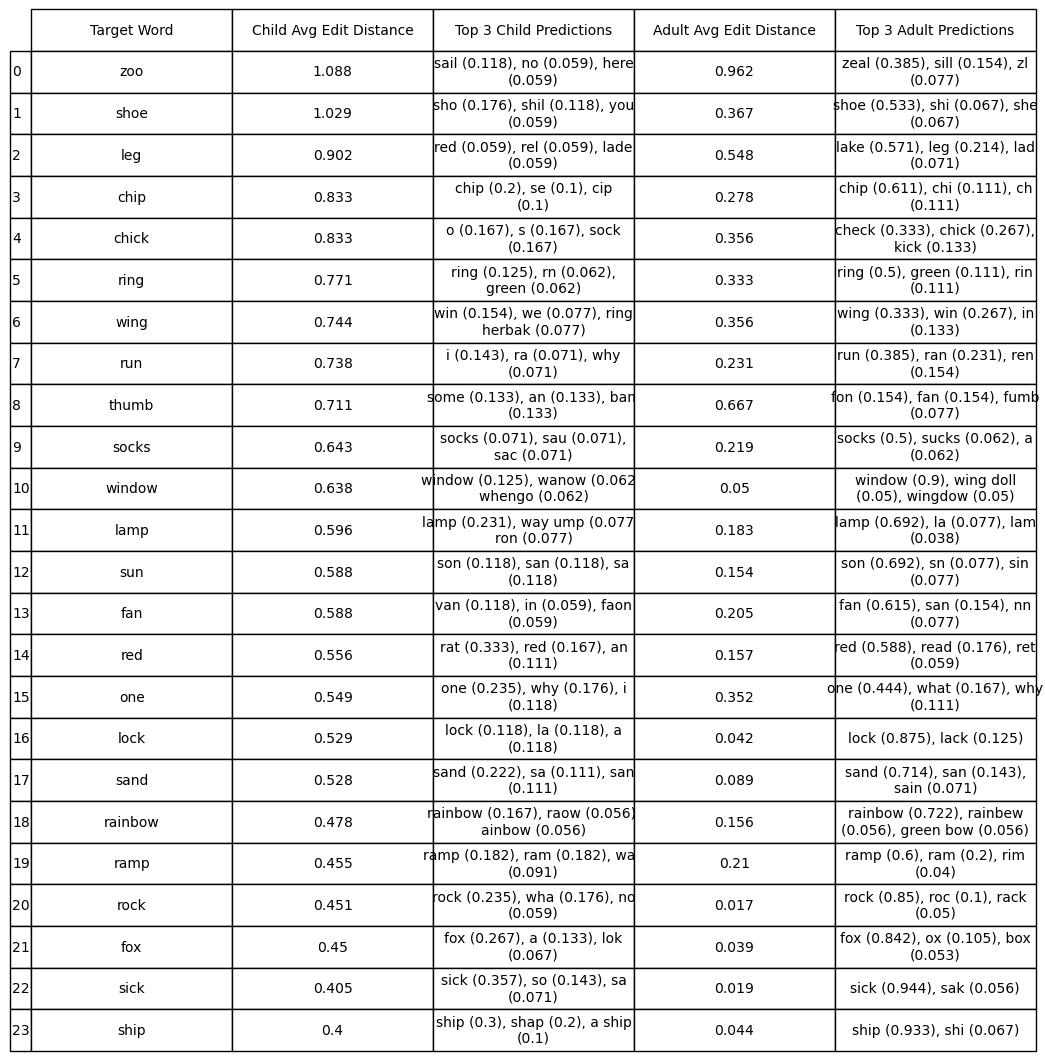

In [2]:
# Re-import necessary libraries after code execution reset
import pandas as pd
import matplotlib.pyplot as plt
import pandas.plotting as pd_plotting
import ast
import textwrap

# Load the CSV file again
df = pd.read_csv('top_predictions.csv')

# Extract and format top 3 predictions and their counts
def extract_top_3(pred_dict_str):
    pred_dict = ast.literal_eval(pred_dict_str)
    sorted_preds = sorted(pred_dict.items(), key=lambda x: -x[1])[:3]
    return ', '.join([f"{word} ({count})" for word, count in sorted_preds])

# Wrap long prediction strings for table display
def wrap_text(text, width=30):
    return '\n'.join(textwrap.wrap(text, width=width))

# Add top-3 prediction summaries and apply wrapping
df['Top 3 Child Predictions'] = df['top_5_predictions_x'].apply(extract_top_3).apply(lambda x: wrap_text(x, width=30))
df['Top 3 Adult Predictions'] = df['top_5_predictions_y'].apply(extract_top_3).apply(lambda x: wrap_text(x, width=30))

# Create a cleaner display table
detailed_table_df = df[[
    'transcription',
    'avg_edit_distance_x', 'Top 3 Child Predictions',
    'avg_edit_distance_y', 'Top 3 Adult Predictions'
]].rename(columns={
    'transcription': 'Target Word',
    'avg_edit_distance_x': 'Child Avg Edit Distance',
    'avg_edit_distance_y': 'Adult Avg Edit Distance'
})

# Round edit distances
detailed_table_df['Child Avg Edit Distance'] = detailed_table_df['Child Avg Edit Distance'].round(3)
detailed_table_df['Adult Avg Edit Distance'] = detailed_table_df['Adult Avg Edit Distance'].round(3)

# Plot the updated table
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')
table = pd_plotting.table(ax, detailed_table_df, loc='center', cellLoc='center', colWidths=[0.18]*len(detailed_table_df.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2.5)

# Save the updated image
#plt.savefig('/mnt/data/asr_prediction_table_top3.png', dpi=300, bbox_inches='tight')
plt.show()


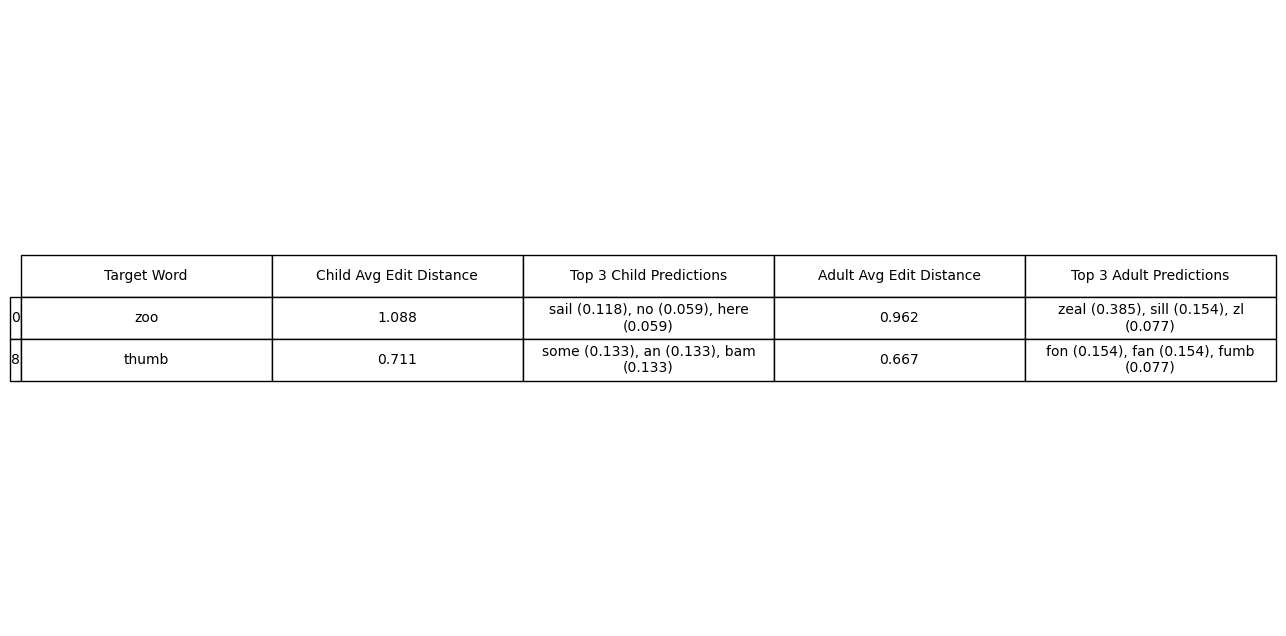

In [19]:
df_example = detailed_table_df[detailed_table_df['Target Word']=='zoo']
df_example = pd.concat([df_example, detailed_table_df[detailed_table_df['Target Word']=='thumb']])

fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = pd_plotting.table(ax, df_example, loc='center', cellLoc='center', colWidths=[0.18]*len(detailed_table_df.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2.5)

In [ ]:
# Melt
melted_df = table_df.melt(
    id_vars='Target Word',
    value_vars=['Child Avg Edit Distance', 'Adult Avg Edit Distance'],
    var_name='Group',
    value_name='Avg Edit Distance'
)
melted_df.head()

,Target Word,Group,Avg Edit Distance
0,zoo,Child Avg Edit Distance,1.088
1,shoe,Child Avg Edit Distance,1.029
2,leg,Child Avg Edit Distance,0.902
3,chip,Child Avg Edit Distance,0.833
4,chick,Child Avg Edit Distance,0.833


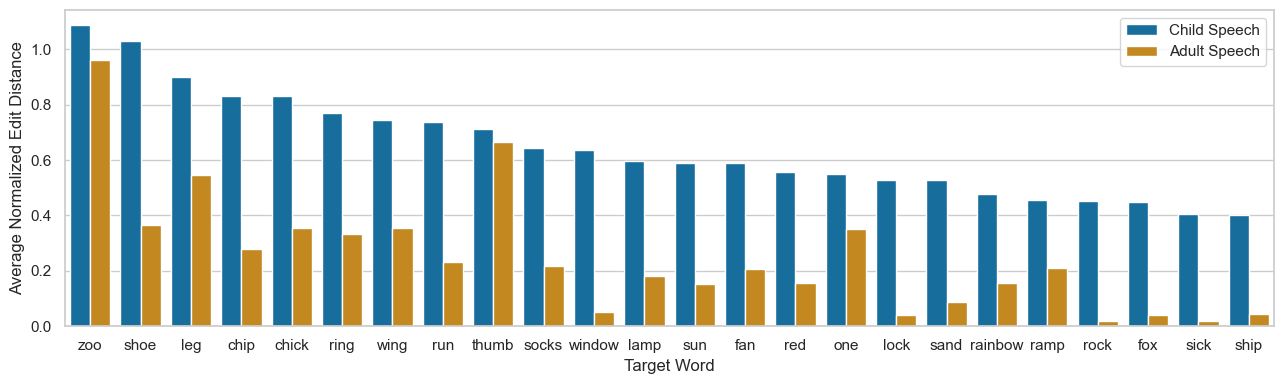

In [421]:
fig, ax = plt.subplots(figsize=(13, 4))
sns.barplot(data=melted_df, x='Target Word', y='Avg Edit Distance', hue='Group')
#plt.xticks(rotation=45)  # optional: rotate x-axis labels if they overlap
#plt.title("Top 10 words with largest average edit distance")
plt.ylabel('Average Normalized Edit Distance')
plt.xlabel('Target Word')
plt.tight_layout()
fig = plt.gcf()

L = plt.legend()
L.get_texts()[0].set_text('Child Speech')
L.get_texts()[1].set_text('Adult Speech')

# Save the figure
# fig.savefig('top_10_words.png', dpi=300)

fig.savefig('all_predictions_bar.png', dpi=300)

plt.show()

In [481]:
# Step 1: Count occurrences of each phone in reference transcriptions
true_phone_counts = Counter()

for _, row in optimal_kids_df.iterrows():
    true = ast.literal_eval(row['transcription_phones']) if isinstance(row['transcription_phones'], str) else row['transcription_phones']
    true_phone_counts.update(true)

# Step 2: Normalize the existing error counters
normalized_subs = {pair: count / true_phone_counts[pair[0]] for pair, count in all_subs.items() if true_phone_counts[pair[0]] > 0}
normalized_dels = {phone: count / true_phone_counts[phone] for phone, count in all_dels.items() if true_phone_counts[phone] > 0}

# Optional: Normalize insertions by total reference phone tokens
total_reference_phones = sum(true_phone_counts.values())
normalized_ins = {phone: count / total_reference_phones for phone, count in all_ins.items()}

# Step 3: Convert to DataFrames
subs_df = pd.DataFrame(normalized_subs.items(), columns=['substitution', 'proportion']).sort_values(by='proportion', ascending=False)
dels_df = pd.DataFrame(normalized_dels.items(), columns=['deletion', 'proportion']).sort_values(by='proportion', ascending=False)
ins_df = pd.DataFrame(normalized_ins.items(), columns=['insertion', 'proportion']).sort_values(by='proportion', ascending=False)

# ---- 1. Flatten substitutions into separate target and predicted phone columns ----
subs_df[['target_phone', 'predicted_phone']] = pd.DataFrame(subs_df['substitution'].tolist(), index=subs_df.index)
subs_df = subs_df.drop(columns=['substitution'])

# ---- 2. Sum proportions of substitutions for each target phone ----
sub_target_props = subs_df.groupby('target_phone')['proportion'].sum()

# ---- 3. Get deletion proportions (already grouped by deleted phone) ----
del_target_props = dels_df.set_index('deletion')['proportion']

# ---- 4. Get insertion proportions (by inserted phone) ----
ins_target_props = ins_df.set_index('insertion')['proportion']

# ---- 5. Combine all into a single DataFrame ----
error_counts = pd.concat([sub_target_props, del_target_props, ins_target_props], axis=1)
error_counts.columns = ['substitution', 'deletion', 'insertion']
error_counts = error_counts.fillna(0)

# ---- 6. Add a column for total error proportion per phone ----
error_counts['total_error_prop'] = (
    error_counts['substitution'] + 
    error_counts['deletion'] + 
    error_counts['insertion']
)

# ---- 7. Convert to final sorted summary table ----
error_summary = error_counts.sort_values(by='total_error_prop', ascending=False).reset_index()
error_summary = error_summary.rename(columns={'index': 'phone'})

# ---- 8. Output the top error-prone phones ----
df_errors = error_summary.head(20)

# Melt
df_errors_new = df_errors.melt(id_vars=['phone'], value_vars=['substitution', 'deletion', 'insertion'], var_name='edit_type', value_name='prop_edit')


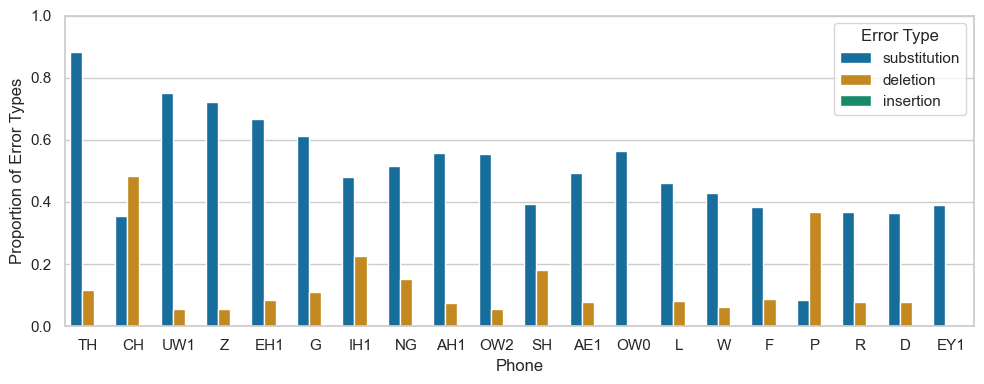

In [485]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(data=df_errors_new, x='phone', y='prop_edit', hue='edit_type')
#plt.title('Frequency of errors by type for top 10 mispredicted phones')
plt.ylabel('Proportion of Error Types')
plt.ylim(0, 1)
plt.xlabel('Phone')
plt.legend(title="Error Type")
plt.tight_layout()
fig = plt.gcf()

# Save the figure
fig.savefig('missed_phones.png', dpi=300)

plt.show()

In [441]:
labels = []
for _, row in subs_df.iterrows():
    label = row['target_phone'] + ' -> ' + row['predicted_phone']
    labels.append(label)
    
subs_df['label'] = labels
subs_df

,proportion,target_phone,predicted_phone,label
44,0.393939,NG,N,NG -> N
11,0.361111,EH1,AE1,EH1 -> AE1
62,0.333333,Z,S,Z -> S
51,0.294118,TH,F,TH -> F
83,0.277778,G,K,G -> K
...,...,...,...,...
200,0.009091,IH1,R,IH1 -> R
76,0.008333,N,OW0,N -> OW0
22,0.008333,N,NG,N -> NG
2,0.008333,N,W,N -> W


In [21]:
# Step 1: Count occurrences of each phone in reference transcriptions
true_phone_counts = Counter()

for _, row in adults_df.iterrows():
    true = ast.literal_eval(row['transcription_phones']) if isinstance(row['transcription_phones'], str) else row['transcription_phones']
    true_phone_counts.update(true)

# Step 2: Normalize 
normalized_subs = {pair: count / true_phone_counts[pair[0]] for pair, count in all_subs.items() if true_phone_counts[pair[0]] > 0}

# Step 3: Convert to DataFrames
adults_subs_df = pd.DataFrame(normalized_subs.items(), columns=['substitution', 'proportion']).sort_values(by='proportion', ascending=False)

# ---- 1. Flatten substitutions into separate target and predicted phone columns ----
adults_subs_df[['target_phone', 'predicted_phone']] = pd.DataFrame(adults_subs_df['substitution'].tolist(), index=adults_subs_df.index)
adults_subs_df = adults_subs_df.drop(columns=['substitution'])

# ---- 2. Sum proportions of substitutions for each target phone ----
sub_target_props = adults_subs_df.groupby('target_phone')['proportion'].sum()

labels = []
for _, row in adults_subs_df.iterrows():
    label = row['target_phone'] + ' -> ' + row['predicted_phone']
    labels.append(label)
    
adults_subs_df['label'] = labels
adults_subs_df

NameError: name 'Counter' is not defined

In [465]:
common_subs_df = pd.merge(subs_df.head(10), adults_subs_df, on='label', how='left')
common_subs_df = common_subs_df[['label', 'proportion_x', 'proportion_y']]
common_subs_df = common_subs_df.rename(columns={'proportion_x':"Child Speech", "proportion_y":"Adult Speech"})

# Melt
melted_df = common_subs_df.melt(
    id_vars='label',
    value_vars=['Child Speech', 'Adult Speech'],
    var_name='Group',
    value_name='Proportion'
)
melted_df

,label,Group,Proportion
0,NG -> N,Child Speech,0.393939
1,EH1 -> AE1,Child Speech,0.361111
2,Z -> S,Child Speech,0.333333
3,TH -> F,Child Speech,0.294118
4,G -> K,Child Speech,0.277778
5,SH -> S,Child Speech,0.212121
6,AH1 -> AY1,Child Speech,0.176471
7,D -> T,Child Speech,0.173077
8,OW2 -> OW0,Child Speech,0.166667
9,UW1 -> OW1,Child Speech,0.166667


NameError: name 'sns' is not defined

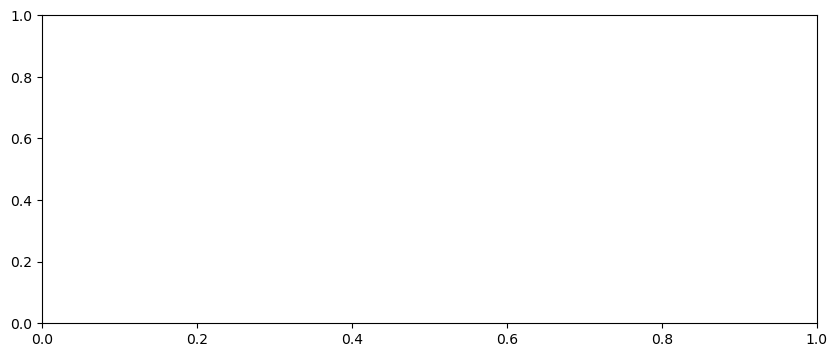

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(data=melted_df, x='label', y='Proportion', errorbar=None, hue='Group')
plt.ylabel('Normalized Frequency of Substitution')
plt.ylim(0, 1)
plt.xlabel('Substitution Type')
plt.legend(title=None)
plt.tight_layout()
fig = plt.gcf()

# Save the figure
fig.savefig('top_substitutions.png', dpi=300)

plt.show()